# COUPLING Encoder And Decoder

The output neurons from the last layer if the encoder bloack in the encoder is passed to all the decoder bloks of the deocder

the decoder block take
the <b>output of previous block</b> as a <b>Query</b> and
the <b>Ouptut of the encoder</b> and generates <b>key value pair</b> to pass to the query 

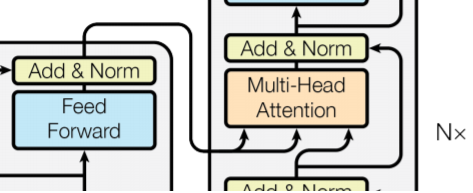


## Eg of Seq to Seq with attention

Transformers and seq2seq wth attn follow the same pronciple with slight variations

seq2seq uses prev hidden state of decoder and all encoders hidden state to find current time step output




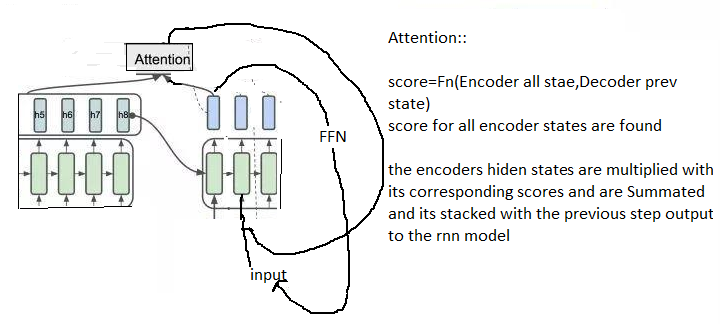

s2s uses only previous time step but transformer uses all previous outputs

it is used to find how much  attention has to be paid to each of encoders output(encoded input) with the help of deocder previous output/outputs in order to produce the output for the current time step

In [ ]:
class Coupling():
    def __init__(self,dim,heads):
        
        self._Keyss=Linear(dim,dim*heads) # for self attention Feed_Forward(dim,dim) it has only one vector to store the attention between two words where multi head attention has muliple vectors to store relationship/attention between two words for improved performance
        self._Query=Linear(dim,dim*heads)
        self._Value=Linear(dim,dim*heads)
        self._Unify=Linear(dim*heads,dim)
        self.head=heads
        self.D=dim
        self.sm=Softmax()
        
    def forward(self,Encoder_op,Decoder_ip):# after embedding layer and adding with pos enc the input reaches attention layer
        
        #initially we are passing the input vectors through (key,query ,value) Weights
        queries=self._Query.forward(Decoder_ip) #determines which values to focus
        keys   =self._Keyss.forward(Encoder_op) #hint to find score for its value pair      
        values =self._Value.forward(Encoder_op) # extract interesting features  
        #print(self._Keyss.Weight,'\n\n',self._Query.Weight,'\n\n')
        
        
        # batchsize,seqlen,head*dim   ====>>>   batchsize*head,seqlen,dim since the dimensions of sequence will react with other all sequences within same head ,heads wont react with each other
        sha=list(keys.shape)
        self.sha_=sha.copy()     
        sha[-1]=int(sha[-1]/self.head)
        sha[0]*=self.head
        self.sha=sha
        
        
        # Weight are reshaped

        keys=keys.reshape(sha)
        queries=queries.reshape(sha)
        values=values.reshape(sha)
        
        # parameters are saved for backpropagation
        self.param={}
        self.param['k']=keys   
        self.param['q']=queries
        self.param['v']=values
        
        
        # Each Query is iterated with each other key to Get its score with the corresponding word
        
        #print(keys,'\n\n',queries,'\n\n')       
        W_=np.matmul(queries, np.transpose(keys, (0, 2, 1)))/(self.D**0.5)
        print('\n\n',queries,'\n\n',keys,'\n\n',W_,'\n\n')
        W=self.sm(W_) 

        self.W=W
        
        Y=np.matmul(W,values) # the scores are multiplied with the values and they are added
        # concat the heads
        Y=Y.reshape(self.sha_)
        op=self._Unify.forward(Y)
        
        return op
    
    def backward(self,err,lr):
        
        dY=self._Unify.backward(err,lr)
        dY=dY.reshape(self.sha)
        
        dval=np.matmul(self.W,dY)
        
        
        dW =np.matmul(self.param['v'],np.transpose(dY, (0, 2, 1)))
        
        dW_=self.sm.backward(dW)
        dkeys=np.matmul(dW_,self.param['q'])/(self.D**0.5)
        dque=np.matmul(dW_,self.param['k'])/(self.D**0.5)
        
        dkeys=dkeys.reshape(self.sha_)
        dque=dque.reshape(self.sha_)
        dval=dval.reshape(self.sha_)
        
        der_enc =self._Query.backward(dque,lr)      
        der_dec =self._Keyss.backward(dkeys,lr)+self._Value.backward(dval,lr)
        
        return der_enc,der_dec       
        
        
    
        
    

# Autoregressive Attention network

making self attention in auto regressive fasion

In [ ]:
class SelfAttn():
    def __init__(self,dim,heads):
        
        self._Keyss=Linear(dim,dim*heads) # for self attention Feed_Forward(dim,dim) it has only one vector to store the attention between two words where multi head attention has muliple vectors to store relationship/attention between two words for improved performance
        self._Query=Linear(dim,dim*heads)
        self._Value=Linear(dim,dim*heads)
        self._Unify=Linear(dim*heads,dim)
        self.head=heads
        self.D=dim
        self.sm=Softmax()
        self.param={}
        
    def forward(self,input_vec,time_step,mask=None):# after embedding layer and adding with pos enc the input reaches attention layer
        ts=time_step
        #initially we are passing the input vectors through (key,query ,value) Weights
        queries=self._Query.forward(input_vec,ts) #determines which values to focus
        keys   =self._Keyss.forward(input_vec,ts) #hint to find score for its value pair      
        values =self._Value.forward(input_vec,ts) # extract interesting features  
        #print(self._Keyss.Weight,'\n\n',self._Query.Weight,'\n\n')
        
        
        # batchsize,seqlen,head*dim   ====>>>   batchsize*head,seqlen,dim since the dimensions of sequence will react with other all sequences within same head ,heads wont react with each other
        sha=list(keys.shape)
        self.param[str(ts)+'sha_']=sha.copy()     
        sha[-1]=int(sha[-1]/self.head) # shapes will be same in all time steps
        sha[0]*=self.head
        self.param[str(ts)+'sha']=sha
        
        
        # Weight are reshaped

        keys=keys.reshape(sha)
        queries=queries.reshape(sha)
        values=values.reshape(sha)
        
        # parameters are saved for backpropagation
        
        self.param[str(ts)+'k']=keys   
        self.param[str(ts)+'q']=queries
        self.param[str(ts)+'v']=values
        
        
        # Each Query is iterated with each other key to Get its score with the corresponding word
        
        #print(keys,'\n\n',queries,'\n\n')       
        W_=np.matmul(queries, np.transpose(keys, (0, 2, 1)))#/(self.D**0.5)
        
        if(mask):
            W_=Masking(W_)# masking will be done each word will not have acces to future word
            
        
        #print('\n\n',queries,'\n\n',keys,'\n\n',W_,'\n\n')
        W=self.sm(W_) 

        
        self.param[str(ts)+'W']=W
        
        Y=np.matmul(W,values) # the scores are multiplied with the values and they are added
        # concat the heads
        Y=Y.reshape(sha_)
        op=self._Unify.forward(Y,ts)
        
        return op
    
    def backward(self,err,time_step,lr):
        ts=time_step
        dY=self._Unify.backward(err,ts,lr)
        dY=dY.reshape(self.param[str(ts)+'sha'])
        
        dval=np.matmul(self.param[str(ts)+'W'],dY)
        
        
        dW =np.matmul(self.param[[str(ts)+'v'],np.transpose(dY, (0, 2, 1)))
        
        dW_=self.sm.backward(dW)
        dkeys=np.matmul(dW_,self.param[[str(ts)+'q'])/(self.D**0.5)
        dque=np.matmul(dW_,self.param[[str(ts)+'k'])/(self.D**0.5)
        sha_=self.param[str(ts)+'sha_']
        dkeys=dkeys.reshape(sha_)
        dque=dque.reshape(sha_)
        dval=dval.reshape(sha_)
        
        der_inp =self._Keyss.backward(dkeys,ts,lr)
        der_inp+=self._Query.backward(dque,ts,lr)
        der_inp+=self._Value.backward(dval,ts,lr)
        
        return der_inp       
        
        
    
        
    